In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据

In [2]:
dirPath = "data preprocessed\\unnormalized"

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

((33600, 18), (14400, 18), (12000, 17))

划分数据集特征和标签：

In [3]:
trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]
trainSet.shape, validateSet.shape

((33600, 17), (14400, 17))

# 实现评测指标

In [4]:
def calcF1(predictLabel, realLabel, printRes=False):
    '''给定算法得到的分类结果和实际的分类结果，计算评测指标
    注意：标签为1则为正标签，标签不为1则为负标签'''
    def safeDivide(a, b):
        '''子函数：当分母为0时返回除式结果为 -1'''
        return a/b if b != 0 else 0
    
    TP = Counter(np.logical_and(predictLabel==1, realLabel==1))[True]
    FN = Counter(np.logical_and(predictLabel!=1, realLabel==1))[True]
    FP = Counter(np.logical_and(predictLabel==1, realLabel!=1))[True]
    if(printRes):
        print("TP FN FP", TP, FN, FP)
    F1 = safeDivide(2*TP, 2*TP+FN+FP)
    return F1

print('test 1: normal one')
calcF1(arr([1, 1, 0, 0]), arr([1, 0, 1, 0]), True)
print('\ntest 2: may have zero division error')
calcF1(arr([0, 0, 1, 0]), arr([1, 0, 1, 0]), True)

test 1: normal one
TP FN FP 1 1 1


0.5


test 2: may have zero division error
TP FN FP 1 1 0


0.6666666666666666

# KNN

In [36]:
def knn_classify(dataSet, labels, k, inputVector):
    '''使用knn对输入的向量进行分类，使用欧式距离'''
    #得到输入向量与数据集的差值的平方
    diffMat = (dataSet - inputVector)**2
    #计算每一行上元素的和
    distancesSquare = diffMat.sum(axis=1)
    #可以不用计算距离，用距离的平方也可以，这样效率更高
    #print(distancesSquare)
    #得到 K 个近邻的下标
    kNeighborsIndex  = distancesSquare.argpartition(k-1)[0:k]
    
    #计算 K 个近邻的距离倒数
    kDatas = 1/distancesSquare[kNeighborsIndex]
    #得到 对应的 K 个标签
    kLabels = labels[kNeighborsIndex]
    
    predictLabel = np.NAN
    maxDis = -np.inf
    for i in np.unique(kLabels):
        dis = np.sum(kDatas[kLabels==i]) 
        #print(dis)
        if dis > maxDis:
            maxDis = dis
            predictLabel = i
    #返回分类结果
    return predictLabel

##############测试程序#######################
knn_classify(arr([[1,1,0,0],
              [0,1,1,1],
              [1,0,0,1]]), arr([1, 0, 1]), 3, arr([0,1,1,0]))
##############测试程序#######################

0

# 调参

所调参数只有K。

In [26]:
def run_knn_classify(dataSet, k):
    ansLabel = []
    for i in tnrange(len(dataSet), leave=False):
        ansLabel.append(knn_classify(trainSet, trainSetLabel, k, dataSet[i]))
    return arr(ansLabel)

def getTestF1(k):
    ansLabel = run_knn_classify(validateSet, k)
    return calcF1(ansLabel, validateSetLabel)

In [38]:
testRange = np.arange(1, 10)
testRange

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
F1s = []
for k in tnrange(1, len(testRange)+1):
    F1s.append(getTestF1(k))

In [40]:
bestK = testRange[np.argmax(F1s)]
bestK, np.max(F1s) 

(1, 0.87826086956521743)

In [41]:
InteractiveShell.ast_node_interactivity = "none"

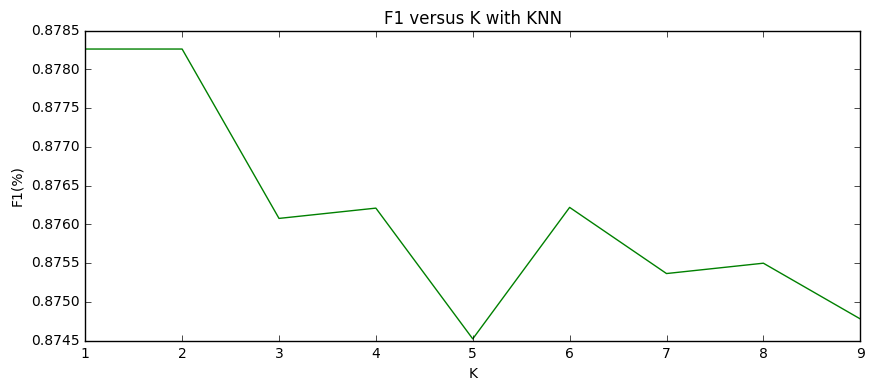

In [42]:
fig,ax = plt.subplots() 
fig.set_size_inches(10, 4)
plt.plot(testRange, F1s, 'g')
plt.xlabel('K')
plt.ylabel('F1(%)')
plt.title("F1 versus K with KNN")
plt.show()
plt.close()

12-23：

结果表明，加权对于当前70%训练集30%验证集的数据集划分情况下，与step2相比准确率都是一样的。

但是，有提升的是，在K $\in$ 1-5之间的F1值比step2的要好，因此猜测将整个训练集用来训练加权KNN，当K取大于1的值的时候可能有比较好的效果。

转自step5进行测试。

In [43]:
InteractiveShell.ast_node_interactivity = "all"

# 应用算法到测试集

In [44]:
# ansLabel = run_knn_classify(testSet, bestK)
# np.savetxt('.\\rank\\47_v2.csv', ansLabel, fmt="%d", delimiter="\n")

In [45]:
# Counter(ansLabel)
# one = Counter(ansLabel)[1.0]
# zero = Counter(ansLabel)[0.0]
# one/(one + zero)